In [22]:
import matplotlib.pyplot as plot
import numpy as np
from scipy.stats import norm
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
import pandas as pd
%run -i utils.py

### Load parameters

In [23]:
all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

### Match-up

In [32]:
home_team = 'Crystal Palace'
away_team = 'Man City'

#### Sampling Team Performance

In [33]:
tp = all_teams_params.values
N = 50000

goals_home = np.zeros(N)
goals_away = np.zeros(N)
for i in range(N):
    params = np.zeros(np.shape(tp)[0])
    for j in range(np.shape(tp)[0]):
        params[j] = np.random.normal(tp[j, 0], tp[j, 1])
    intercept = params[0]
    mu = params[1]
    a = params[2:(len(teams) + 2)]
    d = params[(len(teams) + 2):((2 * len(teams)) + 2)]
    result_lambdas = predict_fixtures(np.reshape(np.array([home_team, away_team]), ((1, 2))),
                                      teams, intercept, mu, a, d)
    goals_home[i] = np.random.poisson(result_lambdas[0][0])
    goals_away[i] = np.random.poisson(result_lambdas[1][0])

---------------------
Chance of home win:  0.21776
Chance of draw:  0.22778
Chance of away win:  0.55446
---------------------


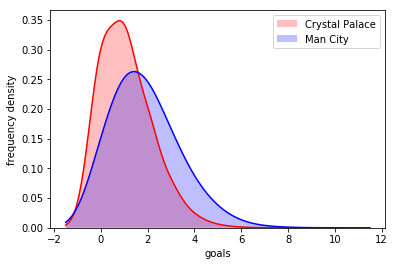

In [34]:
p1=sns.kdeplot(goals_home, shade=True, color="r", bw=0.5)
p1=sns.kdeplot(goals_away, shade=True, color="b", bw=0.5)
plot.xlabel("goals")
plot.ylabel('frequency density')
plot.legend([home_team, away_team])

print('---------------------')
print('Chance of home win: ', sum(goals_home > goals_away) / N)
print('Chance of draw: ', sum(goals_home == goals_away) / N)
print('Chance of away win: ', sum(goals_home < goals_away) / N)
print('---------------------')

#### Sampling player performance

-----------------------------
Chance of 1 goal:  0.20518
Chance of 2 goals:  0.03858
Chance of 3 goals:  0.00492
-----------------------------
-----------------------------
Chance of 1 assist:  0.14806
Chance of 2 assists:  0.01798
Chance of 3 assists:  0.0016
-----------------------------


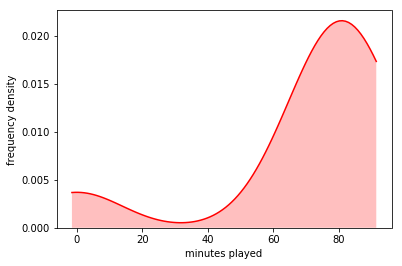

-----------------------------
Chance of clean sheet:  0.29332
-----------------------------
-----------------------------
Expected Minutes:  69.92254
-----------------------------


In [35]:
player = 'Raheem Sterling'
starting = None  # either true false or None
home_players = list(all_players_params.loc[all_players_params.index[all_players_params['team'] == home_team], 'player'])
away_players = list(all_players_params.loc[all_players_params.index[all_players_params['team'] == away_team], 'player'])
if (player not in home_players) and (player not in away_players):
    print('Player doesnt play for either home or away team')
else:
    
    team_player = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'team'].values[0]
    
    clean_sheets = np.zeros(N)
    mins_played = np.zeros(N)
    goals = np.zeros(N)
    assists = np.zeros(N)
    
    a_mins = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'a_mins'].values[0]
    b_mins = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'b_mins'].values[0]
    a_games = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'a_games'].values[0]
    b_games = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'b_games'].values[0]
    a_goals = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'a_goals'].values[0]
    b_goals = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'b_goals'].values[0]
    c_goals = all_players_params.loc[all_players_params.index[all_players_params['player'] == player], 'c_goals'].values[0]
    
    for i in range(N):
        mins_played[i] = sample_mins_played(a_mins, b_mins, a_games, b_games, starting)
        clean_sheets[i] = (mins_played[i] >= 60) * (np.array([goals_home[i], goals_away[i]])[int(home_team == team_player)] == 0)
        goa, assi = sample_goals_and_assists(a_goals, b_goals, c_goals, int(np.array([goals_home[i], goals_away[i]])[int(away_team == team_player)]), mins_played[i])
        goals[i] = goa
        assists[i] = assi
    
    print('-----------------------------')
    print('Chance of 1 goal: ', sum(goals == 1) / N)
    print('Chance of 2 goals: ', sum(goals == 2) / N)
    print('Chance of 3 goals: ', sum(goals == 3) / N)
    print('-----------------------------')
    
    print('-----------------------------')
    print('Chance of 1 assist: ', sum(assists == 1) / N)
    print('Chance of 2 assists: ', sum(assists == 2) / N)
    print('Chance of 3 assists: ', sum(assists == 3) / N)
    print('-----------------------------')
    
    if all(mins_played == 0) == False:
        p1=sns.kdeplot(mins_played, shade=True, color="r", bw=0.5)
        plot.xlabel("minutes played")
        plot.ylabel('frequency density')
        plot.show()
    
    print('-----------------------------')
    print('Chance of clean sheet: ', sum(clean_sheets) / N)
    print('-----------------------------')
    
    print('-----------------------------')
    print('Expected Minutes: ', np.mean(mins_played))
    print('-----------------------------')